In [1]:
import warnings
warnings.filterwarnings(action='once')

In [2]:
import numpy as np
import layoutparser as lp

model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.7],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})


/home/perezkay/anaconda3/envs/Capstone/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/perezkay/anaconda3/envs/Capstone/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272128894/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


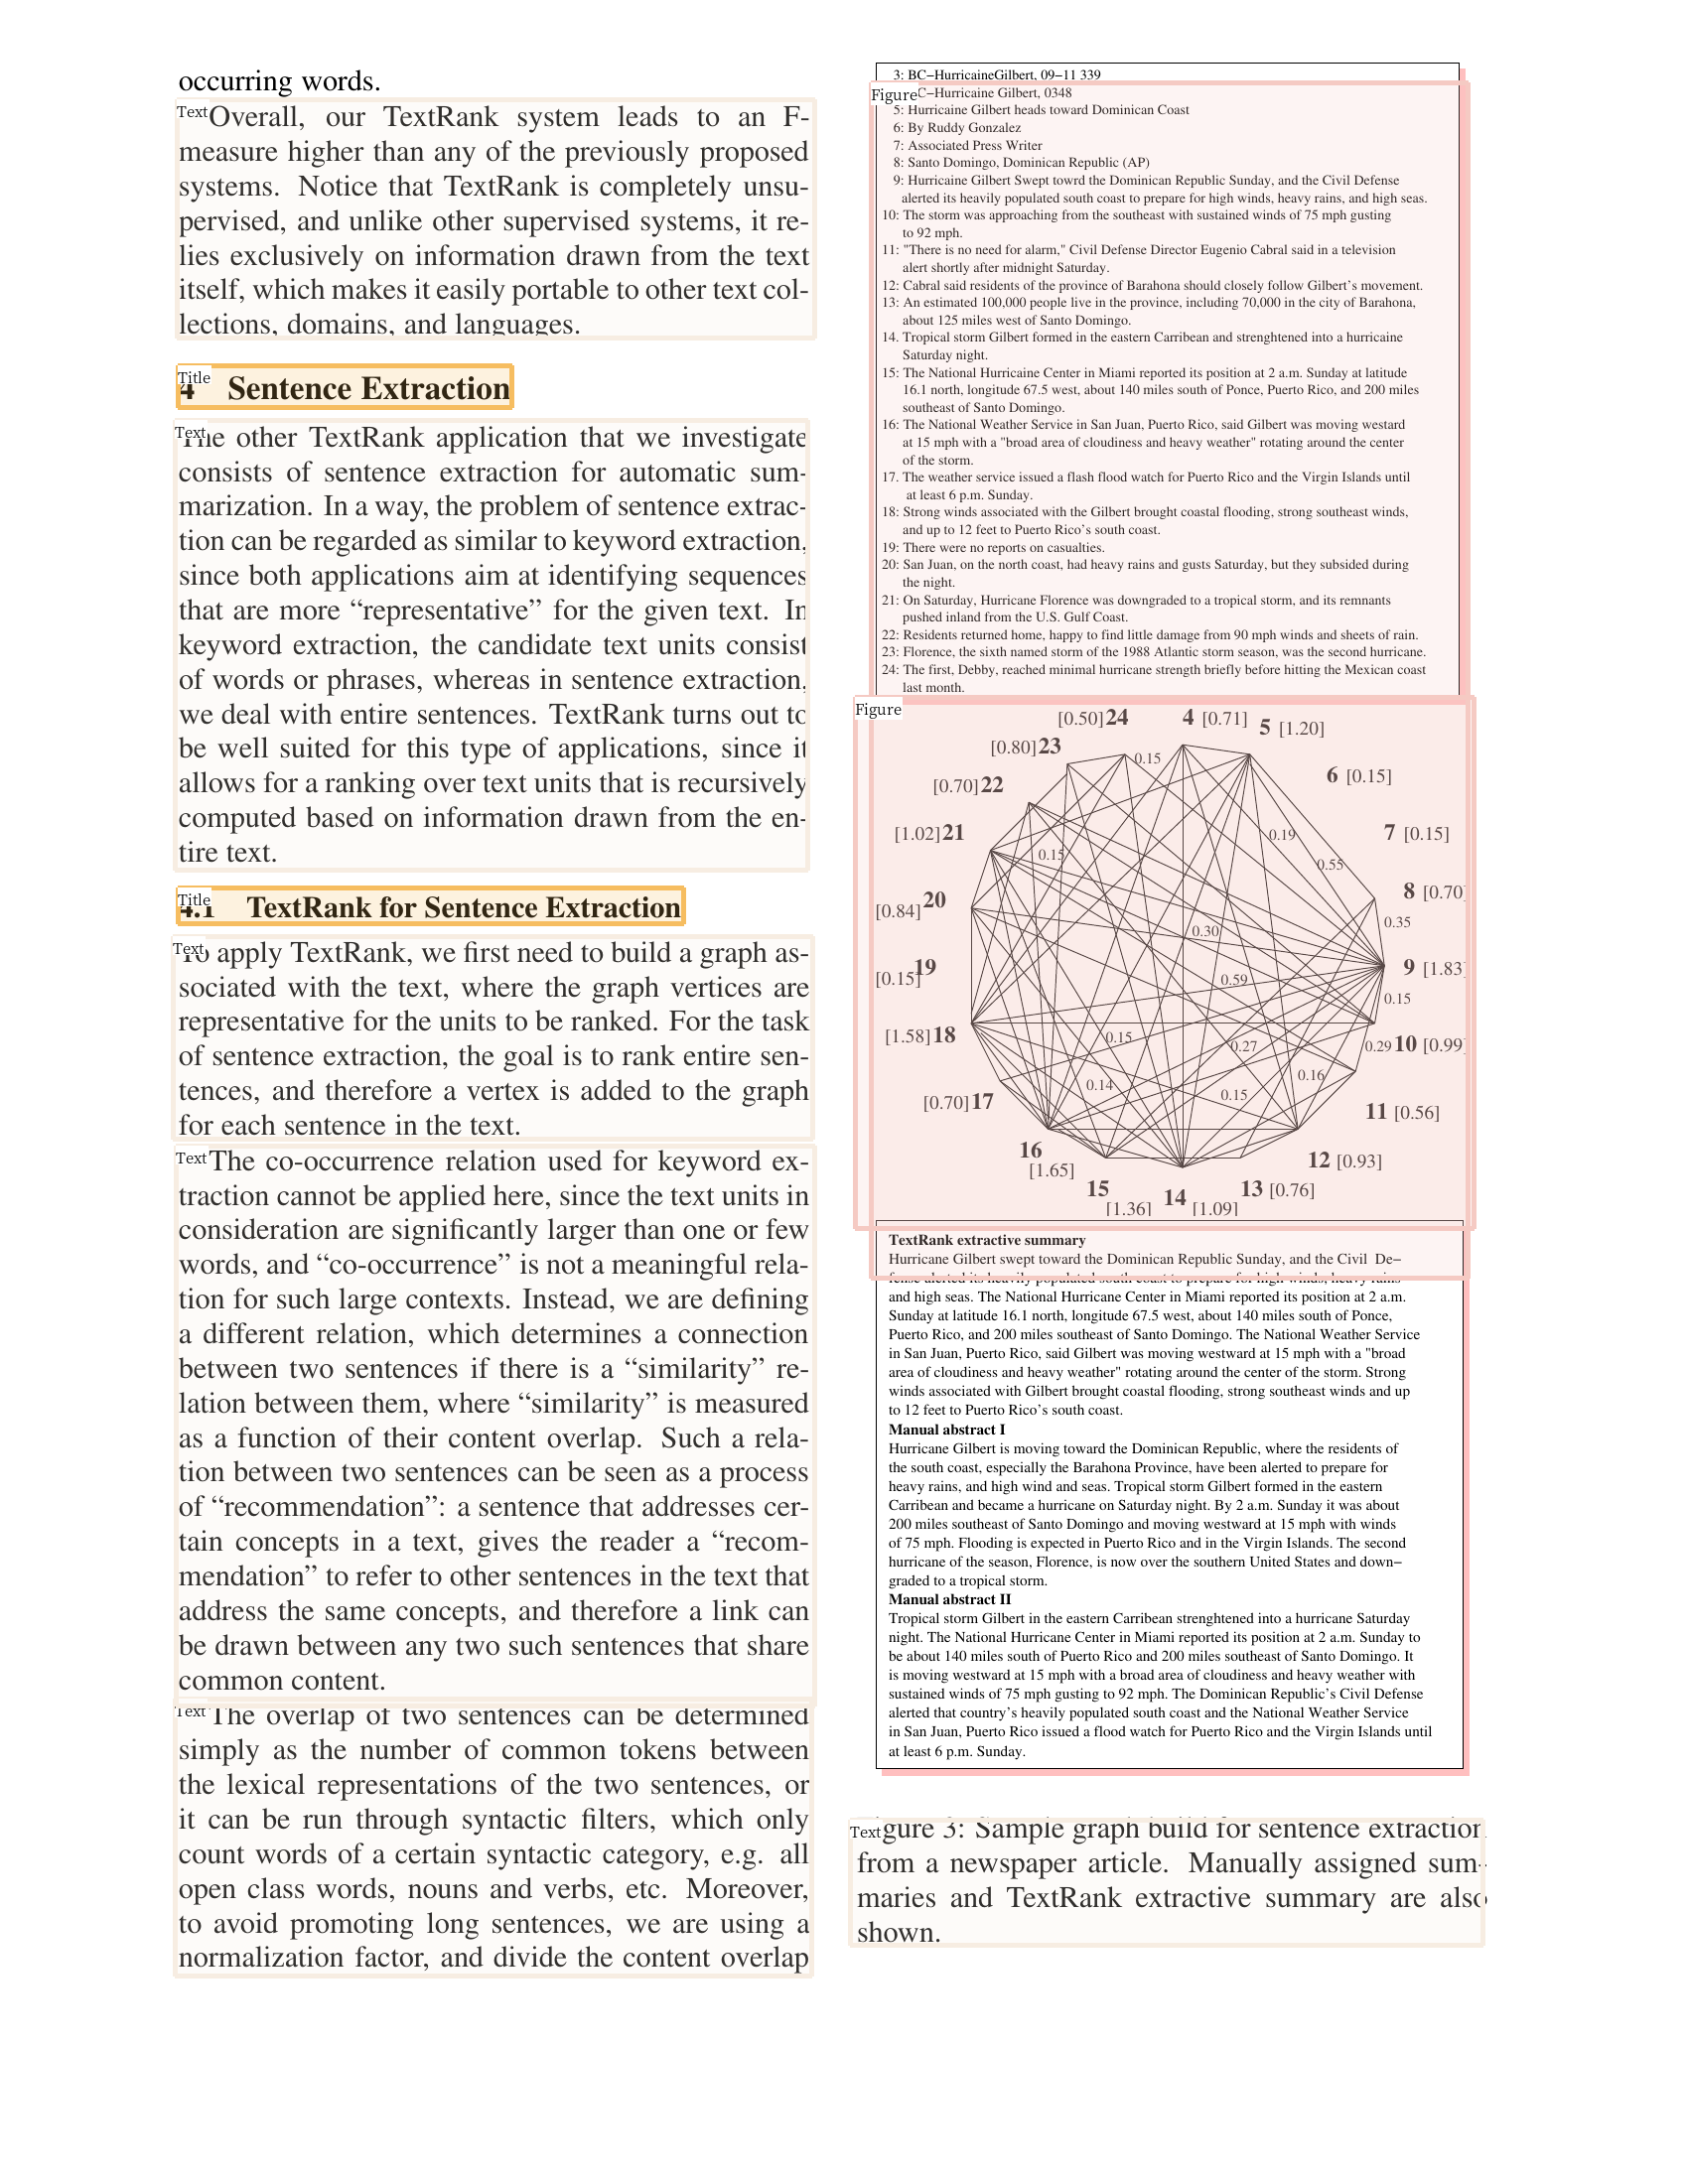

In [3]:
from pdf2image import convert_from_path

pdf_images = convert_from_path("test papers/textrank algorithm paper.pdf")
img = np.asarray(pdf_images[5])
layout = model.detect(img)
lp.draw_box(img, layout,  box_width=5, box_alpha=0.2, show_element_type=True)



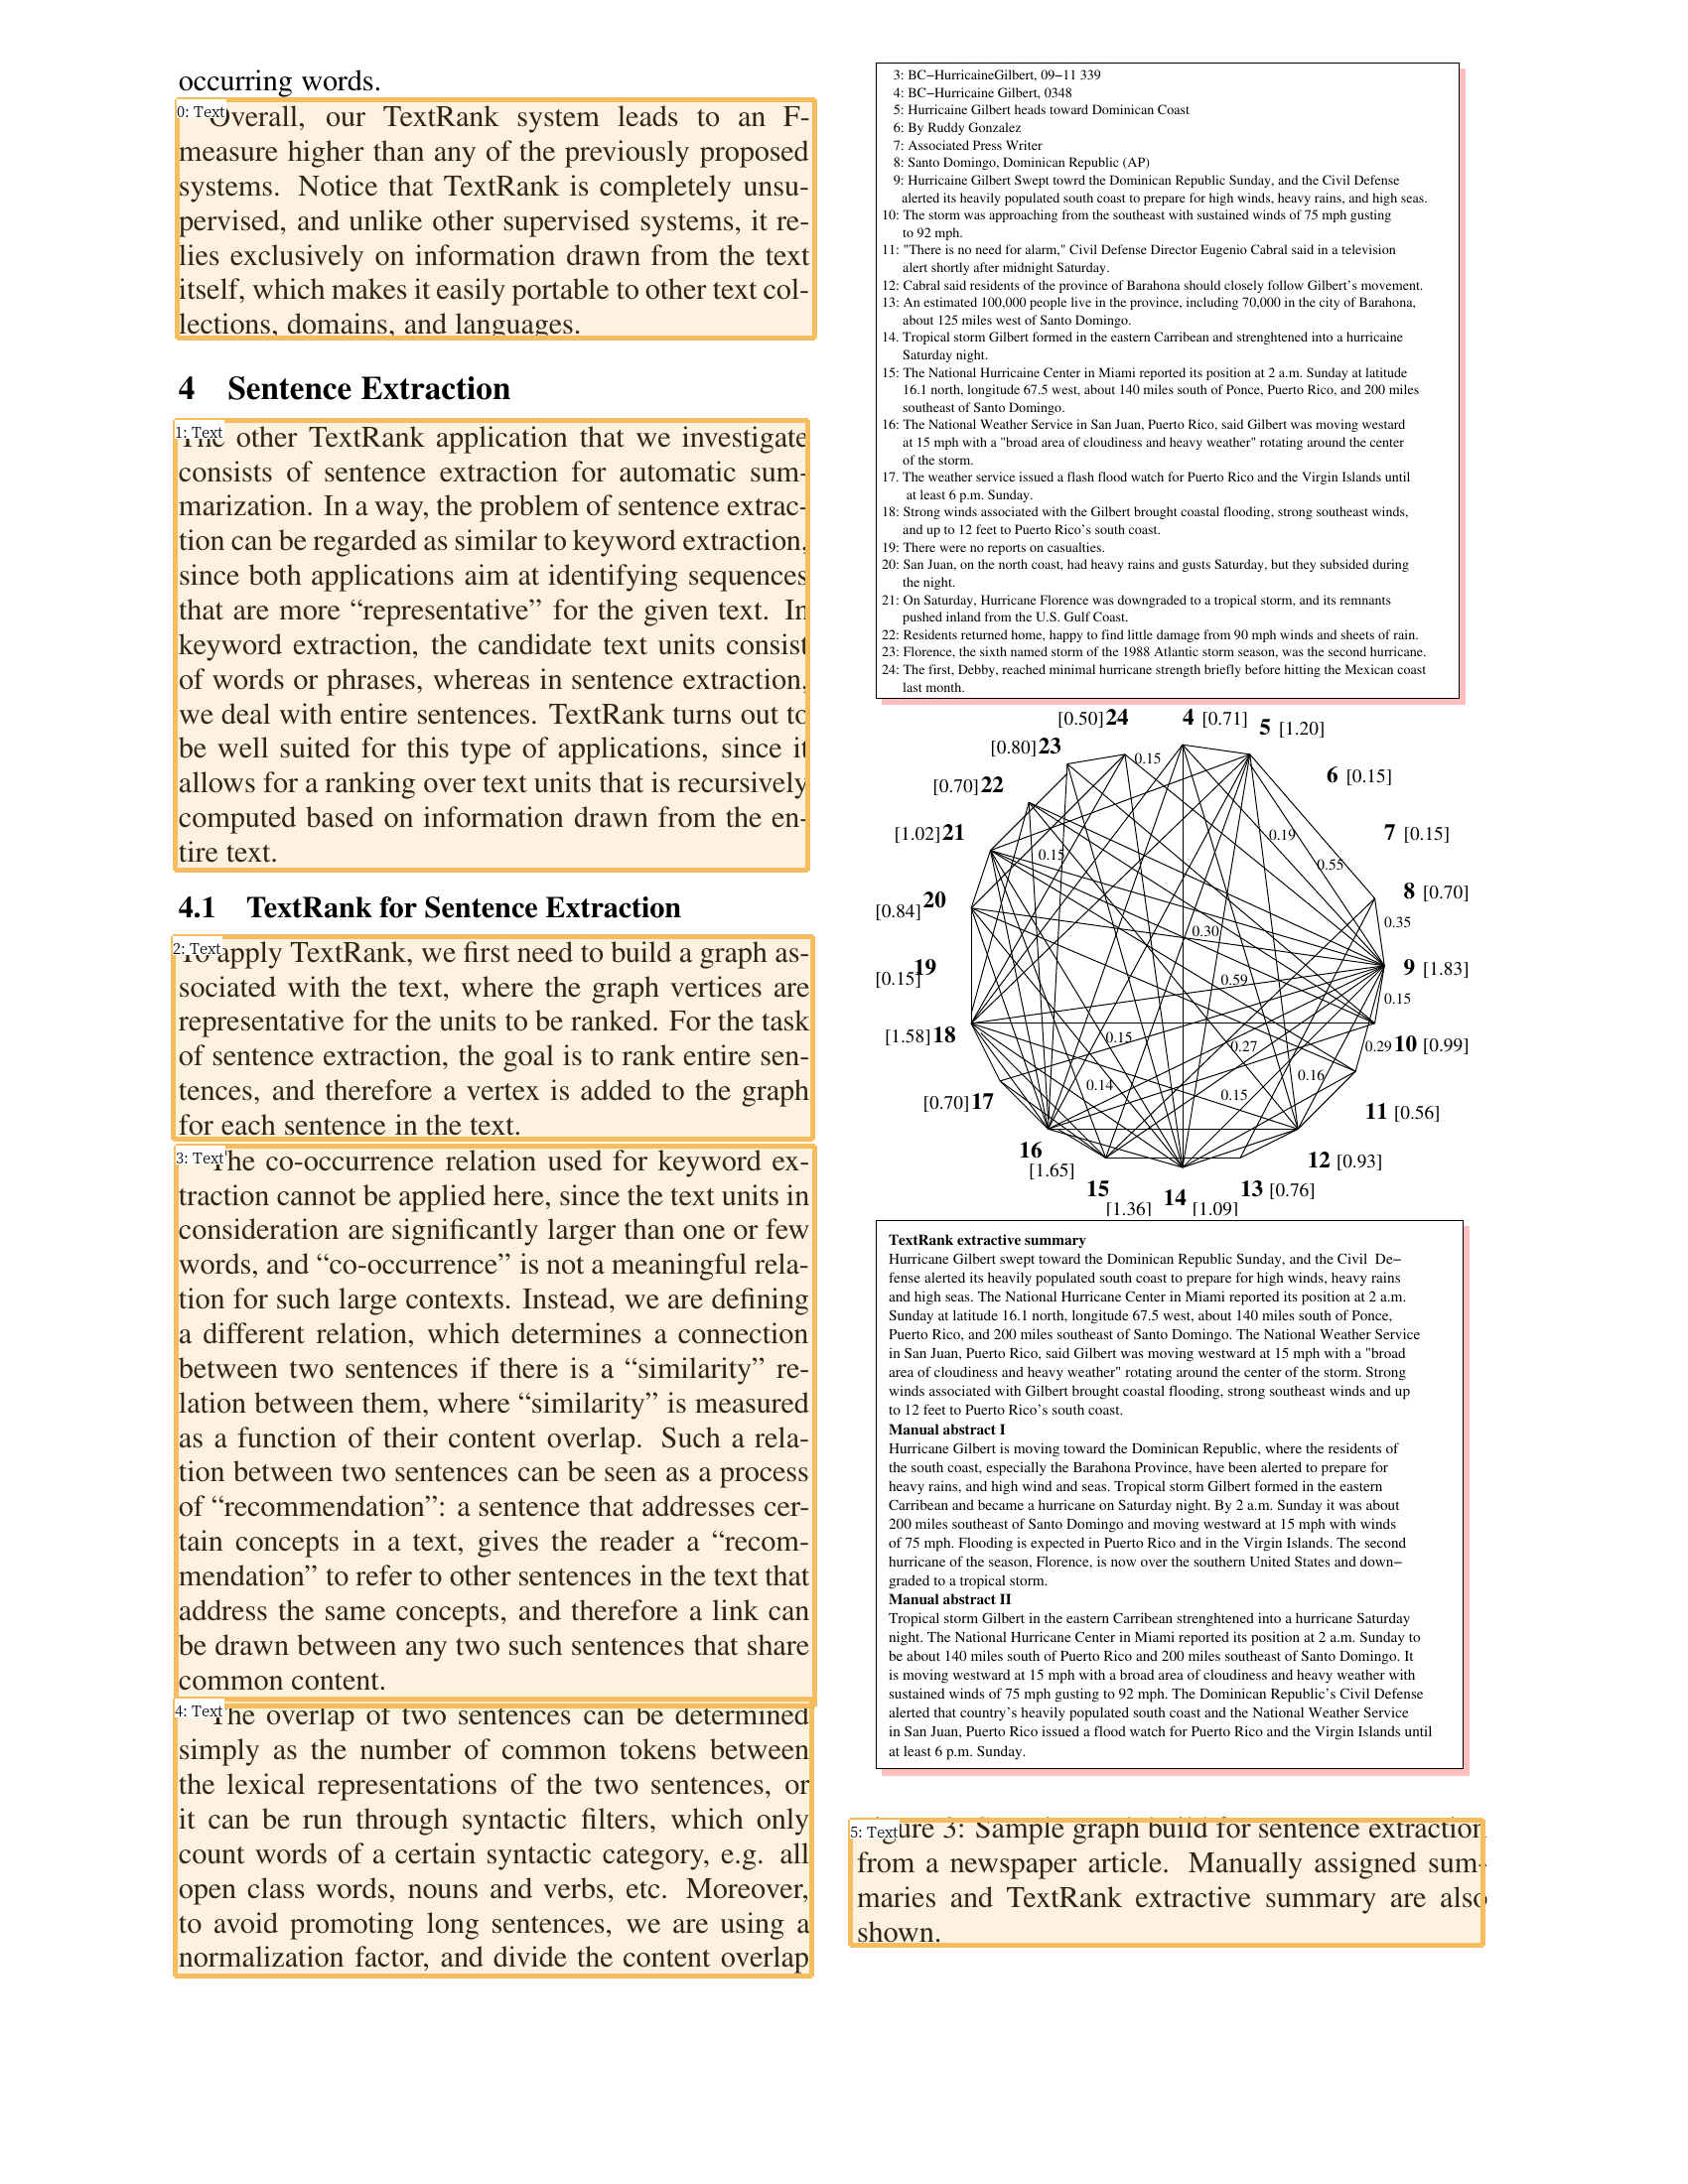

In [94]:
# this seems to work on both 1 and 2 column papers

# filter out text blocks
text_blocks = lp.Layout([block for block in layout if block.type == 'Text'])

# filter out title blocks
title_blocks = lp.Layout([block for block in layout if block.type == "Title"])

image_width = len(img[0])

# Sort element ID of the left column based on y1 coordinate
left_interval = lp.Interval(0, image_width / 2, axis='x').put_on_canvas(img)

# returns a list of layout elements on the left of the page?
left_blocks = text_blocks.filter_by(left_interval, center=True)._blocks

# sort by their order number
left_blocks.sort(key = lambda block : block.coordinates[1])

# Sort element ID of the right column based on y1 coordinate
right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# Sort the overall element ID starts from left column
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

lp.draw_box(img, text_blocks,  box_width=5, box_alpha=0.2, show_element_type=True, show_element_id=True)

In [3]:
ocr_agent = lp.TesseractAgent(languages='eng')

In [96]:
for block in text_blocks:

    # Crop image around the detected layout
    segment_image = (block.pad(left=15, right=15, top=5, bottom=5).crop_image(img))
    
    # Perform OCR
    text = ocr_agent.detect(segment_image)

    # Save OCR result
    block.set(text=text, inplace=True)

In [101]:
for block in text_blocks:
    print(block.text)

Overall, our TextRank system leads to an F-
measure higher than any of the previously proposed
systems. Notice that TextRank is completely unsu-
pervised, and unlike other supervised systems, it re-
lies exclusively on information drawn from the text
itself, which makes it easily portable to other text col-
lections, domains, and languages.

The other TextRank application that we investigate
consists of sentence extraction for automatic sum-
marization. In a way, the problem of sentence extrac-
tion can be regarded as similar to keyword extraction,
since both applications aim at identifying sequences
that are more “representative” for the given text. In
keyword extraction, the candidate text units consist
of words or phrases, whereas in sentence extraction,
we deal with entire sentences. TextRank turns out to
be well suited for this type of applications, since it
allows for a ranking over text units that is recursively
computed based on information drawn from the en-
tire text.

To a

In [5]:
from pdf2image import convert_from_path
import numpy as np
import layoutparser as lp
import re

model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.7],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

ocr_agent = lp.TesseractAgent(languages='eng')

pdf_images = convert_from_path("test papers/textrank algorithm paper.pdf")

def sort_textblock_ids(page_img):
    # Returns a Layout with the text blocks from the given image. The text block IDs are
    # in order as they appear on the page (i.e the first paragraph is ID 0, next is ID 1, etc)
    
    # both of these funcs need the actual img and the num? if we're doing this in a loop
    #page_img = np.asarray(pdf_images[img_num])
    
    layout = model.detect(page_img)
    # filter out text blocks
    text_blocks = lp.Layout([block for block in layout if block.type == 'Text'])

    # filter out title blocks
    #title_blocks = lp.Layout([block for block in layout if block.type == "Title"])

    image_width = len(page_img[0])

    # Sort element ID of the left column based on y1 coordinate
    left_interval = lp.Interval(0, image_width / 2, axis='x').put_on_canvas(page_img)

    # returns a list of layout elements on the left of the page?
    left_blocks = text_blocks.filter_by(left_interval, center=True)._blocks

    # sort by their order number
    left_blocks.sort(key = lambda block : block.coordinates[1])

    # Sort element ID of the right column based on y1 coordinate
    right_blocks = [b for b in text_blocks if b not in left_blocks]
    right_blocks.sort(key = lambda b:b.coordinates[1])

    # Sort the overall element ID starts from left column
    text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])
    return text_blocks

def clean_text(text):
    # removes newline characters
    text = re.sub("\n", " ", text)

    # removes the occurence of "\x0c" which I believe is a tab character? not sure, but it's not needed
    text = re.sub("\\x0c", "", text)

    # merges together words that get split due to line breaks (e.g sen- tence)
    text = re.sub("([a-z])-\s", r"\1", text)
    return text


def convert_single_page_layout_parser(page_img):
    
    #img = np.asarray(pdf_images[img_num])
    #layout = model.detect(img)
    text_blocks = sort_textblock_ids(page_img)
    
    for block in text_blocks:

        # Crop image around the detected layout
        segment_image = (block.pad(left=15, right=15, top=5, bottom=5).crop_image(page_img))

        # Perform OCR
        text = ocr_agent.detect(segment_image)

        # Save OCR result
        block.set(text=text, inplace=True)
   
    # could probably save all text in a list?
    page_text = []
    for block in text_blocks:
        text = clean_text(block.text)
        page_text.append(text)
        
    return page_text

# page_image = np.asarray(pdf_images[0])
# text = convert_single_page_layout_parser(page_image)
# print(text)


In [8]:
%%time
pdf_images = convert_from_path("test papers/textrank algorithm paper.pdf")

# this seems to work! it went all the way through the conclusion section but skipped the references
all_text = []
for page in pdf_images:
    page_image = np.asarray(page)
    all_text += convert_single_page_layout_parser(page_image)
#print(all_text)

/home/perezkay/anaconda3/envs/Capstone/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/perezkay/anaconda3/envs/Capstone/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, 

CPU times: user 6.18 s, sys: 3.92 s, total: 10.1 s
Wall time: 1min 2s


In [9]:
def dump_to_txtfile(paper_text, file_name):
    txt_file = open(file_name, "w")
    for txt in paper_text:
        txt_file.write(txt + " ")
    txt_file.close()

dump_to_txtfile(all_text, "textrank.txt")